# Env Prepare

In [10]:
# Install Pytorch & other libraries
!pip install "torch==2.1.2" tensorboard

# Install Hugging Face libraries
!pip install  --upgrade \
  "transformers==4.36.2" \
  "datasets==2.16.1" \
  "accelerate==0.26.1" \
  "evaluate==0.4.1" \
  "bitsandbytes==0.42.0" \
  # "trl==0.7.10" # \
  # "peft==0.7.1" \

# install peft & trl from github
!pip install git+https://github.com/huggingface/trl@a3c5b7178ac4f65569975efadc97db2f3749c65e --upgrade
!pip install git+https://github.com/huggingface/peft@4a1559582281fc3c9283892caea8ccef1d6f5a4f --upgrade

!pip install openai

!pip install faiss-cpu


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 96.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [24]:
import pandas as pd
import numpy as np
from datasets import load_dataset, Dataset
from transformers import DPRContextEncoderTokenizerFast
from transformers import DPRContextEncoder
from transformers import RagRetriever, RagTokenizer, RagSequenceForGeneration
import json
import openai
import time
import datetime
import math
import faiss
import pickle
import torch

# Tools

In [12]:
def tokenize(corpus, tokenizer = "facebook/dpr-ctx_encoder-multiset-base"):
  ctx_tokenizer = DPRContextEncoderTokenizerFast.from_pretrained(tokenizer)

  outputs = ctx_tokenizer(
      corpus['title'],
      corpus['text'],
      truncation = True,
      padding = 'longest',
      return_tensors = 'pt'
  )

  print('------Tokenization Done------')
  input_ids = outputs['input_ids']

  return input_ids

In [29]:
def encode(input_ids, corpus, encoder = "facebook/dpr-ctx_encoder-multiset-base", batch_size = 16):
  if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
  else:
    print("No GPU is available")
  # Encode
  ctx_encoder = DPRContextEncoder.from_pretrained(encoder)

  # move the encoder model to the GPU
  ctx_encoder = ctx_encoder.to(device = device)

  # no need for gradient descent
  torch.set_grad_enabled(False)

  # Track elapsed time & the current batch number for progress updates
  t0 = time.time()
  step = 0
  batch_size = batch_size

  num_passages = input_ids.size()[0]
  num_batches = math.ceil(num_passages / batch_size)

  # Accumulate embedded passages in the list
  #SH_embeds_batches = []
  embeds_batches = []

  print('Generating embeddings for {:,} passages...'.format(num_passages))

  for i in range(0, num_passages, batch_size):
    if step % 100 == 0 and not step == 0: # update every 100 batches
      elapsed = format_time(time.time() - t0)
      print("Batch{:>5} of {:>5}. Elasped:{:}.".format(step, num_batches, elapsed))

    # Select the next batch and move them to the GPU
    batch_ids = input_ids[i:i+16, :]
    batch_ids = batch_ids.to(device)

    # Run the encoder
    outputs = ctx_encoder(
        batch_ids,
        return_dict = True
    )

    embeddings = outputs["pooler_output"]

    # Bring the embeddings back over from the GPU and convert to numpy (out of pytorch)
    embeddings = embeddings.detach().cpu().numpy()

    embeds_batches.append(embeddings)

    step += 1

  print("------DONE------")
  embeddings = np.concatenate(embeds_batches, axis=0)

  # Adjust the dict into Dataset object
  corpus_df = pd.DataFrame(corpus)
  corpus_dataset = Dataset.from_pandas(corpus_df)


  embeddings_list_array = []
  for i in range(embeddings.shape[0]):
    embeddings_list_array.append(embeddings[i,:])

  corpus_dataset = corpus_dataset.add_column("embeddings", embeddings_list_array)

  return corpus_dataset

In [14]:
def Faiss_index(corpus_dataset, dim = 768, m = 128):
  # Faiss index
  dim = dim
  m = m

  # Use the Faiss implementation of HNSW for fast approximate nearest neighbor search
  index = faiss.IndexHNSWFlat(dim, m, faiss.METRIC_INNER_PRODUCT)
  corpus_dataset.add_faiss_index(column = "embeddings", index_name = "embeddings", custom_index = index, faiss_verbose = True)

  return corpus_dataset

In [21]:
def process_RAG_data(corpus, tokenizer = "facebook/dpr-ctx_encoder-multiset-base", encoder = "facebook/dpr-ctx_encoder-multiset-base", batch_size = 16, dim = 768, m = 128):
  input_ids = tokenize(corpus, tokenizer = "facebook/dpr-ctx_encoder-multiset-base")
  corpus_dataset = encode(input_ids, corpus, encoder = "facebook/dpr-ctx_encoder-multiset-base", batch_size = 16)
  corpus_dataset = Faiss_index(corpus_dataset)

  return corpus_dataset

In [20]:
def prepare_model(corpus_dataset, retrieve_model = "facebook/rag-sequence-nq", tokenize_model = "facebook/rag-sequence-nq", generate_model = "facebook/rag-sequence-nq", Use_dummy_dataset = False):
  retriever = RagRetriever.from_pretrained(
      retrieve_model,
      use_dummy_dataset = False,
      indexed_dataset = corpus_dataset, # Use our own dataset
      index_name = "embeddings_index")
  tokenizer = RagTokenizer.from_pretrained(tokenize_model)
  model = RagSequenceForGeneration.from_pretrained(
    "facebook/rag-sequence-nq",
    retriever = retriever)

  return retriever, tokenizer, model

In [34]:
def ask_question(question):
  t0 = time.time()

  input_ids = tokenizer.question_encoder(question, return_tensors = "pt")['input_ids']
  generated = model.generate(input_ids)
  generated_str = tokenizer.batch_decode(generated, skip_special_tokens = True)[0]

  print("Q: " + question)
  print("A: '{:}'". format(generated_str))

  print("\nResponse took %.2f seconds" %(time.time() - t0))

# Data Prepare

In [ ]:
from datasets import load_dataset

dataset = load_dataset("teknium/openhermes")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

## Data Prepare (OpenHermes)

In [ ]:
dataset = load_dataset("teknium/openhermes", split="train")
dataset = dataset.shuffle().select(range(12500))

In [ ]:
# Convert dataset to OAI messages
system_message = """You are a language model (LLM) being trained to perform various tasks.
You need to do the question-answering task.
Your goal is to understand and respond accurately to the prompts provided.
Please generate appropriate responses for the following tasks:

"""

def create_conversation(sample):
  return {
    "messages": [
      {"role": "system", "content": system_message},
      {"role": "user", "content": sample["instruction"]},
      {"role": "assistant", "content": sample["output"]}
    ]
  }

dataset = dataset.map(create_conversation, remove_columns=dataset.features,batched=False)
# split dataset into 10,000 training samples and 2,500 test samples
dataset = dataset.train_test_split(test_size=2500/12500)

print(dataset["train"][345]["messages"])

# save datasets to disk
dataset["train"].to_json("train_dataset.json", orient="records")
dataset["test"].to_json("test_dataset.json", orient="records")

Map:   0%|          | 0/12500 [00:00<?, ? examples/s]

[{'content': 'You are a language model (LLM) being trained to perform various tasks. \nYou need to do the question-answering task. \nYour goal is to understand and respond accurately to the prompts provided. \nPlease generate appropriate responses for the following tasks:\n\n', 'role': 'system'}, {'content': 'Design an algorithm to solve an interesting problem', 'role': 'user'}, {'content': "One interesting problem that could be solved using an algorithm is the Knapsack Problem. This problem arises in resource allocation and decision making, where the given items with varying weights and values are placed in a knapsack of limited capacity. The goal is to achieve the maximum total value in the knapsack.\n\nAlgorithm to solve the Knapsack Problem:\n1. Start by setting the knapsack capacity to zero, and an empty set for selected items.\n2. Sort the items according to their value per unit weight in descending order.\n3. Loop through the items one by one, and for each item:\n    a. Check if

Creating json from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

4065301

## Use local data

In [ ]:
from datasets import load_dataset

# Load jsonl data from disk
dataset = load_dataset("json", data_files="train_dataset.json", split="train")

Generating train split: 0 examples [00:00, ? examples/s]

## Check data format

In [ ]:
import json

DATA_PATH = "/content/train_dataset.json"

# Load the dataset
with open(DATA_PATH, 'r', encoding='utf-8') as f:
    items = [json.loads(line) for line in f]

class DataFormatError(Exception):
    pass

def check_data_for_format_errors(items: list):

    for line_num, batch in enumerate(items):
        prefix = f"Error in line #{line_num + 1}: "
        if not isinstance(batch, dict):
            raise DataFormatError(
                f"{prefix}Each line in the provided data should be a dictionary"
            )

        if "messages" not in batch:
            raise DataFormatError(
                f"{prefix}Each line in the provided data should have a 'messages' key"
            )

        if not isinstance(batch["messages"], list):
            raise DataFormatError(
                f"{prefix}Each line in the provided data should have a 'messages' key with a list of messages"
            )

        messages = batch["messages"]
        if not any(message.get("role", None) == "assistant" for message in messages):
            raise DataFormatError(
                f"{prefix}Each message list should have at least one message with role 'assistant'"
            )

        for message_num, message in enumerate(messages):
            prefix = f"Error in line #{line_num + 1}, message #{message_num + 1}: "
            if "role" not in message or "content" not in message:
                raise DataFormatError(
                    f"{prefix}Each message should have a 'role' and 'content' key"
                )

            if any(k not in ("role", "content", "name") for k in message):
                raise DataFormatError(
                    f"{prefix}Each message should only have 'role', 'content', and 'name' keys, any other key is not allowed"
                )

            if message.get("role", None) not in ("system", "user", "assistant"):
                raise DataFormatError(
                    f"{prefix}Each message should have a valid role (system, user, or assistant)"
                )


try:
    check_data_for_format_errors(items)
    print("Data format is valid!")
except DataFormatError as e:
    print("Data format is NOT valid!")
    print(e)

Data format is valid!


## Data upload to Anyscale

In [ ]:
import openai

client = openai.OpenAI(
    base_url = "https://api.endpoints.anyscale.com/v1",
    api_key = "esecret_sdgsdi3hh8widiyprdknfnqrr7"
)

file_name = "train_dataset.json"
file = client.files.create(
  file=open(file_name, "rb"),
  purpose="fine-tune",
  #user_provided_filename=file_name,
)

# Fine-tune

## Retrieve the fine-tune job

In [ ]:
status = client.fine_tuning.jobs.retrieve("eftjob_xsg5w9ecpj7p59syx6c2qnw346")
test_dataset = load_dataset("json", data_files="test_dataset.json")
print("------This is the question------")
print(test_dataset['train'][1]['messages'][1]['content'])
print("------This is the answer------")
print(test_dataset['train'][1]['messages'][2]['content'])

------This is the question------
Sure, here's an example question:

An RLC circuit has a resistance of 50 ohms, an inductance of 0.1 henrys, and a capacitance of 1 microfarad. If the circuit is connected to a 120V AC voltage source with a frequency of 60Hz, what is the maximum current that will flow through the circuit and how long will it take for the current to reach this maximum value?
------This is the answer------
To find the maximum current that will flow through the circuit, we first need to determine the impedance (Z) of the RLC circuit. The impedance is given by the formula:

Z = √(R^2 + (XL - XC)^2)

where R is the resistance, XL is the inductive reactance, and XC is the capacitive reactance. 

First, let's find the inductive reactance (XL) and capacitive reactance (XC):

XL = 2 * π * f * L
XC = 1 / (2 * π * f * C)

where f is the frequency, L is the inductance, and C is the capacitance.

Given the values: f = 60 Hz, L = 0.1 H, and C = 1 μF (1 × 10^-6 F)

XL = 2 * π * 60 * 0.

## Answer test questions

In [ ]:
predictions = []
df_pred = pd.DataFrame()
df_pred['prompt'] = ''
df_pred['completion'] = ''
df_predRow = 0

for i in range(10):
  question = test_dataset['train'][i]['messages'][1]['content']
  #answer = test_dataset['train'][i]['messages'][2]['content']
  prompt="Consider the Question: {}\nPlease generate appropriate responses for the question.\n\n###".formatquestion),
  completion = client.completions.create(
        model="meta-llama/Llama-2-13b-chat-hf:shuyi:D33ok8u",
        prompt=prompt
        max_tokens=350,
        temperature=0.5,
  )
  response = completion.choices[0].text.strip()
  predictions.append(response)
  df_pred.loc[df_predRow, 'prompt'] = prompt
  df_pred.loc[df_predRow, 'completion'] = response
  df_predRow += 1
  print(f'-------This is the {i} sample------')
  print(response)

df_pred.to_excel('./content/drive/MyDrive/pred_result/impr_pred.xlsx', sheet_name='Sheet1', index=False)


# Retrieve Data Preprocess
ref: https://youtu.be/rkhHWgg7-Mc?si=dse3qibwvCWb1kIj

## Download wiki dataset

In [ ]:
from datasets import load_dataset

wiki_data = load_dataset("wikipedia", "20220301.simple")

wiki_data["train"].to_json("train_wiki_dataset.json", orient="records")

## Put part of samples into one corpus

In [ ]:
from datasets import load_dataset
wiki_data = load_dataset("json", data_files="/content/drive/MyDrive/retrieve_wiki_data/train_wiki_dataset.json", split="train")
print(wiki_data[1])
print(len(wiki_data))

Generating train split: 0 examples [00:00, ? examples/s]

{'id': '2', 'url': 'https://simple.wikipedia.org/wiki/August', 'title': 'August', 'text': 'August (Aug.) is the eighth month of the year in the Gregorian calendar, coming between July and September. It has 31 days. It is named after the Roman emperor Augustus Caesar.\n\nAugust does not begin on the same day of the week as any other month in common years, but begins on the same day of the week as February in leap years. August always ends on the same day of the week as November.\n\nThe Month \n\nThis month was first called Sextilis in Latin, because it was the sixth month in the old Roman calendar. The Roman calendar began in March about 735\xa0BC with Romulus. October was the eighth month. August was the eighth month when January or February were added to the start of the year by King Numa Pompilius about 700\xa0BC. Or, when those two months were moved from the end to the beginning of the year by the decemvirs about 450\xa0BC (Roman writers disagree). In 153 BC January 1 was determined

In [ ]:
partial_corpus = {}
titles = []
passages = []

for i in range(50000):
  titles.append(wiki_data[i]['title'])
  passages.append(wiki_data[i]['text'])

partial_corpus = {'title': titles, 'text': passages}

## Tokenize passages

In [ ]:
from transformers import DPRContextEncoderTokenizerFast

# Load the tokenizer
ctx_tokenizer = DPRContextEncoderTokenizerFast.from_pretrained("facebook/dpr-ctx_encoder-multiset-base")


# Prepare your data

outputs = ctx_tokenizer(
    partial_corpus['title'],
    partial_corpus['text'],
    truncation = True,
    padding = 'longest',
    return_tensors = 'pt'
)
print('------Tokenization Done------')
input_ids = outputs['input_ids']

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/492 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizerFast'.


------Tokenization Done------


In [ ]:
print(input_ids.shape)

torch.Size([50000, 512])


## Encode

In [ ]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  print("GPU is available")
else:
  print("No GPU is available")

GPU is available


In [ ]:
from transformers import DPRContextEncoder

ctx_encoder = DPRContextEncoder.from_pretrained("facebook/dpr-ctx_encoder-multiset-base")

# move the encoder model to the GPU
ctx_encoder = ctx_encoder.to(device = device)


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-ctx_encoder-multiset-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Encoding will be slow so we can print progress update by using the below function.

In [ ]:
import time
import datetime

def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds = elapsed_rounded))

We need to encode passages in batches due to the GPU's limited memory.

In [ ]:
import math

# no need for gradient descent
torch.set_grad_enabled(False)

# Track elapsed time & the current batch number for progress updates
t0 = time.time()
step = 0
batch_size = 16

num_passages = input_ids.size()[0]
num_batches = math.ceil(num_passages / batch_size)

# Accumulate embedded passages in the list
embeds_batches = []

print('Generating embeddings for {:,} passages...'.format(num_passages))

for i in range(0, num_passages, batch_size):
  if step % 100 == 0 and not step == 0: # update every 100 batches
    elapsed = format_time(time.time() - t0)
    print("Batch{:>5} of {:>5}. Elasped:{:}.".format(step, num_batches, elapsed))

  # Select the next batch and move them to the GPU
  batch_ids = input_ids[i:i+16, :]
  batch_ids = batch_ids.to(device)

  # Run the encoder
  outputs = ctx_encoder(
      batch_ids,
      return_dict = True
  )

  embeddings = outputs["pooler_output"]

  # Bring the embeddings back over from the GPU and convert to numpy (out of pytorch)
  embeddings = embeddings.detach().cpu().numpy()

  embeds_batches.append(embeddings)

  step += 1

print("------DONE------")


Generating embeddings for 50,000 passages...
Batch  100 of  3125. Elasped:0:00:11.
Batch  200 of  3125. Elasped:0:00:23.
Batch  300 of  3125. Elasped:0:00:34.
Batch  400 of  3125. Elasped:0:00:45.
Batch  500 of  3125. Elasped:0:00:56.
Batch  600 of  3125. Elasped:0:01:08.
Batch  700 of  3125. Elasped:0:01:19.
Batch  800 of  3125. Elasped:0:01:30.
Batch  900 of  3125. Elasped:0:01:42.
Batch 1000 of  3125. Elasped:0:01:53.
Batch 1100 of  3125. Elasped:0:02:04.
Batch 1200 of  3125. Elasped:0:02:15.
Batch 1300 of  3125. Elasped:0:02:27.
Batch 1400 of  3125. Elasped:0:02:38.
Batch 1500 of  3125. Elasped:0:02:49.
Batch 1600 of  3125. Elasped:0:03:00.
Batch 1700 of  3125. Elasped:0:03:12.
Batch 1800 of  3125. Elasped:0:03:23.
Batch 1900 of  3125. Elasped:0:03:34.
Batch 2000 of  3125. Elasped:0:03:45.
Batch 2100 of  3125. Elasped:0:03:57.
Batch 2200 of  3125. Elasped:0:04:08.
Batch 2300 of  3125. Elasped:0:04:19.
Batch 2400 of  3125. Elasped:0:04:30.
Batch 2500 of  3125. Elasped:0:04:42.
Batch

Final step: combine the results across all batches

In [ ]:
import numpy as np

embeddings = np.concatenate(embeds_batches, axis=0)

In [ ]:
import pickle

# Save the encoded passages so that we don't need to re-run previous steps
with open('encoded_passages.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

# FAISS index

FAISS is a library for performing fast KNN search. We can use this to perform the similarity search between the question embedding and passages embedding.

The main feature of FAISS is that it implements a number of Approximate Nearest Neighbor (ANN) techniques. KNN can be extremely computationally expensive, so ANN is designed for addressing this by approximating the search and sacrificing accuracy for speed.

The also require that first building an index for the collection of vectors that we'll be searching.

(RAG is using the cosine similarity as the metric for KNN)

## Create index

Generating a FAISS index involves an ANN technique called Hierarchical Navigable Small Worlds (HNSW)

In [ ]:
import faiss

# The dimension of the embeddings to pass to HNSW Faiss index
dim = 768

# The number of bi-directional links created for every new element during
# the HNSW index construction
m = 128

# Use the Faiss implementation of HNSW for fast approximate nearest neighbor search
index = faiss.IndexHNSWFlat(dim, m, faiss.METRIC_INNER_PRODUCT)

Two steps to building the index: train and add

In [ ]:
import pickle

with open('/content/drive/MyDrive/retrieve_wiki_data/encoded_passages.pkl', 'rb') as f:
    embeddings = pickle.load(f)

# Track elapsed time for progress updates
t0 = time.time()

index.train(embeddings)
index.add(embeddings)

print("Adding embeddings to index took", format_time(time.time() - t0))

Adding embeddings to index took 0:00:03


# Process questions

## Question Encoder

We use DPR Question Encoder instead of Context Encoder that we used earlier.

In [ ]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  print("GPU is available")
else:
  print("No GPU is available")

GPU is available


In [ ]:
from transformers import DPRQuestionEncoder

q_encoder = DPRQuestionEncoder.from_pretrained("facebook/dpr-question_encoder-multiset-base")

# Move the encoder model to the GPU
q_encoder = q_encoder.to(device = device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-question_encoder-multiset-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.weight', 'question_encoder.bert_model.pooler.dense.bias']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Question Tokenizer

In [ ]:
from transformers import DPRQuestionEncoderTokenizerFast

q_tokenizer = DPRQuestionEncoderTokenizerFast.from_pretrained("facebook/dpr-question_encoder-multiset-base")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## Example

In [ ]:
import textwrap

# Tokenize the question
input_ids = q_tokenizer.encode("What is machine learning?", return_tensors = "pt")

# Move the question to GPU
input_ids = input_ids.to(device)

# Run the question through BERT and generate the question embedding
outputs = q_encoder(input_ids)
q_embed = outputs['pooler_output']

# Transfer the embeddings to our CPU to do the research
q_embed = q_embed.detach().cpu().numpy()

# Perform search using the FAISS index
# Find the k=3 most similar passages to the question embedding
D, I = index.search(q_embed, k=3)
print("Closest matching indeces:", I)
print("Inner Products:", D)

# Map the indeces back to the original passage text
# Wrap text to 80 characters
wrapper = textwrap.TextWrapper(width = 80)
for i in I[0]:
  print("Index:", i)
  title = partial_corpus["title"][i]
  passage = partial_corpus["text"][i]
  print("Article Title: ", title, "\n")
  print("Passages: ")
  print(wrapper.fill(passage))


Closest matching indeces: [[ 1906 34699 11216]]
Inner Products: [[82.19353  79.139114 78.227715]]
Index: 1906
Article Title:  Artificial intelligence 

Passages: 
Artificial intelligence (AI) is the ability of a computer program or a machine
to think and learn. It is also a field of study which tries to make computers
"smart". They work on their own without being encoded with commands. John
McCarthy came up with the name "Artificial Intelligence" in 1955.  In general
use, the term "artificial intelligence" means a programme which mimics human
cognition. At least some of the things we associate with other minds, such as
learning and problem solving can be done by computers, though not in the same
way as we do. Andreas Kaplan and Michael Haenlein define AI as a system’s
ability to correctly interpret external data, to learn from such data, and to
use those learnings to achieve specific goals and tasks through flexible
adaptation.  An ideal (perfect) intelligent machine is a flexible agen

# Create the model objects

(The previous steps focus on the retrieve part.)

RAG requires that we place the reference data into a Dataset object(from huggingface's datasets library)

We can use a tool called Dataset.from_pandas to do that. Make the partial_corpus which is a dict into Dataset object.

## Re-process the previous wiki data

In [ ]:
from datasets import Dataset
import pandas as pd

partial_corpus_df = pd.DataFrame(partial_corpus)
partial_corpus_dataset = Dataset.from_pandas(partial_corpus_df)
print(partial_corpus_dataset) # Check out the object

In [ ]:
# add the passage embeddings to the Dataset
# we have these in np array, and we need to turn them into a list of array

embeddings_list_array = []
for i in range(embeddings.shape[0]):
  embeddings_list_array.append(embeddings[i,:])

partial_corpus_dataset = dataset.add_column("embeddings", embeddings_list_array)
print(embeddings_list_array)

In [ ]:
# add the index to the Dataset
# we cannot use the previous index object but need to create a new one

# parameters are the same as previous
dim = 768
m = 128

# Use the Faiss implementation of HNSW for fast approximate nearest neighbor search
index = faiss.IndexHNSWFlat(dim, m, faiss.METRIC_INNER_PRODUCT)
partial_corpus_dataset.add_faiss_index(column = "embeddings", index_name = "embeddings_index", custom_index = index, faiss_verbose = True)

## Process Shelock Holmes data

In [22]:
SH_passage_titles = []
SH_passages = []

# Load data
with open ("/content/drive/MyDrive/retrieve_wiki_data/SH.txt", 'r') as f:
    text = f.read()
    words = text.split()
    for i in range(0, len(words), 100): # Loop over the words, incrementing by 100
      chunk_words = words[i: i+100]
      chunk = " ". join(chunk_words)
      chunk = chunk.strip()
      if len(chunk) == 0: # Skip empty chunks
        continue
      SH_passage_titles.append(chunk[0]) # Only one story, no title. So I use the first letter as title
      SH_passages.append(chunk)

SH_corpus = {'title':SH_passage_titles, 'text': SH_passages}

In [46]:
print(SH_corpus)

{'title': ['A', 'h', 'a', 'w', 'f', 'i', 'h', 'h', 'w', 'w', 'o', 'a', 'l', 'E', 't', '"', 's', 'd', 'i', 's', 'w', 'l', 'w', 'n', 'a', '"', 'o', 'f', 'h', '"', '"', 't', 'b', 'o', 'w', 'b', 'q', 'i', '"', 'w', 'g', 'a', 'a', 'a', 'w', 'C', 'w', 'm', 't', 's', 'a', "'", 'i', 'W', 'w', 'm', 'i', 'B', 'a', '"', 'S', 'h', 't', 't', 'g', 'b', 'i', 'c', 'f', '"', 'f', 'c', 'r', 'w', 'S', 'f', 'y', 'c', 'a', 'm', 'a', 'a', '"', 't', 'a', 'b', 't'], 'text': ['A SCANDAL IN BOHEMIA Arthur Conan Doyle Table of contents Chapter 1 Chapter 2 Chapter 3 CHAPTER I To Sherlock Holmes she is always the woman. I have seldom heard him mention her under any other name. In his eyes she eclipses and predominates the whole of her sex. It was not that he felt any emotion akin to love for Irene Adler. All emotions, and that one particularly, were abhorrent to his cold, precise but admirably balanced mind. He was, I take it, the most perfect reasoning and observing machine that the world has seen, but as a lover

In [ ]:
# Tokenize
ctx_tokenizer = DPRContextEncoderTokenizerFast.from_pretrained("facebook/dpr-ctx_encoder-multiset-base")

# Prepare your data

outputs = ctx_tokenizer(
    SH_corpus['title'],
    SH_corpus['text'],
    truncation = True,
    padding = 'longest',
    return_tensors = 'pt'
)
print('------Tokenization Done------')
input_ids = outputs['input_ids']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/492 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizerFast'.


------Tokenization Done------


In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("GPU is available")
else:
  print("No GPU is available")

GPU is available


In [ ]:
# Encode
ctx_encoder = DPRContextEncoder.from_pretrained("facebook/dpr-ctx_encoder-multiset-base")

# move the encoder model to the GPU
ctx_encoder = ctx_encoder.to(device = device)

# no need for gradient descent
torch.set_grad_enabled(False)

# Track elapsed time & the current batch number for progress updates
t0 = time.time()
step = 0
batch_size = 16

num_passages = input_ids.size()[0]
num_batches = math.ceil(num_passages / batch_size)

# Accumulate embedded passages in the list
SH_embeds_batches = []

print('Generating embeddings for {:,} passages...'.format(num_passages))

for i in range(0, num_passages, batch_size):
  if step % 100 == 0 and not step == 0: # update every 100 batches
    elapsed = format_time(time.time() - t0)
    print("Batch{:>5} of {:>5}. Elasped:{:}.".format(step, num_batches, elapsed))

  # Select the next batch and move them to the GPU
  batch_ids = input_ids[i:i+16, :]
  batch_ids = batch_ids.to(device)

  # Run the encoder
  outputs = ctx_encoder(
      batch_ids,
      return_dict = True
  )

  SH_embeddings = outputs["pooler_output"]

  # Bring the embeddings back over from the GPU and convert to numpy (out of pytorch)
  SH_embeddings = SH_embeddings.detach().cpu().numpy()

  SH_embeds_batches.append(SH_embeddings)

  step += 1

print("------DONE------")
SH_embeddings = np.concatenate(SH_embeds_batches, axis=0)

Some weights of the model checkpoint at facebook/dpr-ctx_encoder-multiset-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.weight', 'ctx_encoder.bert_model.pooler.dense.bias']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Generating embeddings for 87 passages...
------DONE------


In [ ]:
# Adjust the dict into Dataset object
SH_corpus_df = pd.DataFrame(SH_corpus)
SH_corpus_dataset = Dataset.from_pandas(SH_corpus_df)


SH_embeddings_list_array = []
for i in range(SH_embeddings.shape[0]):
  SH_embeddings_list_array.append(SH_embeddings[i,:])

SH_corpus_dataset = SH_corpus_dataset.add_column("embeddings", SH_embeddings_list_array)

In [ ]:
# Faiss index
dim = 768
m = 128

# Use the Faiss implementation of HNSW for fast approximate nearest neighbor search
index = faiss.IndexHNSWFlat(dim, m, faiss.METRIC_INNER_PRODUCT)
SH_corpus_dataset.add_faiss_index(column = "embeddings", index_name = "embeddings", custom_index = index, faiss_verbose = True)

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['title', 'text', 'embeddings'],
    num_rows: 87
})

## Use tools to tokenize and encode SH data

In [43]:
SH_corpus_dataset = process_RAG_data(SH_corpus, tokenizer = "facebook/dpr-ctx_encoder-multiset-base", encoder = "facebook/dpr-ctx_encoder-multiset-base", batch_size = 16, dim = 768, m = 128)
retriever, tokenizer, model = prepare_model(SH_corpus_dataset, retrieve_model = "facebook/rag-sequence-nq", tokenize_model = "facebook/rag-sequence-nq", generate_model = "facebook/rag-sequence-nq", Use_dummy_dataset = False)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizerFast'.


------Tokenization Done------
GPU is available


Some weights of the model checkpoint at facebook/dpr-ctx_encoder-multiset-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Generating embeddings for 87 passages...
------DONE------


  0%|          | 0/1 [00:00<?, ?it/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called fr

## Process Exa data

In [8]:
import json
# Preprocess data
Exa_passage_titles = []
Exa_passages = []

with open('/content/drive/MyDrive/OpenHermes-2.5/search_response.json', 'r') as f:
    data = json.load(f)
    titles = data['Title']
    texts = data['Text']
    for i in range(len(titles)):
      title = titles[i]
      text = texts[i]
      words = text.split()

    for i in range(0, len(words), 100): # Loop over the words, incrementing by 100
      chunk_words = words[i: i+100]
      chunk = " ". join(chunk_words)
      chunk = chunk.strip()
      if len(chunk) == 0: # Skip empty chunks
        continue
      Exa_passage_titles.append(title) # Only one story, no title. So I use the first letter as title
      Exa_passages.append(chunk)

Exa_corpus = {'title':Exa_passage_titles, 'text': Exa_passages}

# Tokenize
ctx_tokenizer = DPRContextEncoderTokenizerFast.from_pretrained("facebook/dpr-ctx_encoder-multiset-base")

outputs = ctx_tokenizer(
    Exa_corpus['title'],
    Exa_corpus['text'],
    truncation = True,
    padding = 'longest',
    return_tensors = 'pt'
)

print('------Tokenization Done------')
input_ids = outputs['input_ids']



In [9]:
print(Exa_corpus)

{'title': ['GitHub - matrixgardener/AlgorithmCode: algorithm code', 'GitHub - matrixgardener/AlgorithmCode: algorithm code', 'GitHub - matrixgardener/AlgorithmCode: algorithm code', 'GitHub - matrixgardener/AlgorithmCode: algorithm code', 'GitHub - matrixgardener/AlgorithmCode: algorithm code', 'GitHub - matrixgardener/AlgorithmCode: algorithm code'], 'text': ['Skip to content Toggle navigation Sign up * Product + Actions Automate any workflow + Packages Host and manage packages + Security Find and fix vulnerabilities + Codespaces Instant dev environments + Copilot Write better code with AI + Code review Manage code changes + Issues Plan and track work + Discussions Collaborate outside of code + Explore + All features + Documentation + GitHub Skills + Blog * Solutions + For + Enterprise + Teams + Startups + Education + By Solution + CI/CD & Automation + DevOps + DevSecOps + Case Studies + Customer Stories + Resources *', 'Open Source + GitHub Sponsors Fund open source developers + The 

In [35]:
Exa_corpus_dataset = process_RAG_data(Exa_corpus, tokenizer = "facebook/dpr-ctx_encoder-multiset-base", encoder = "facebook/dpr-ctx_encoder-multiset-base", batch_size = 16, dim = 768, m = 128)
retriever, tokenizer, model = prepare_model(Exa_corpus_dataset, retrieve_model = "facebook/rag-sequence-nq", tokenize_model = "facebook/rag-sequence-nq", generate_model = "facebook/rag-sequence-nq", Use_dummy_dataset = False)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizerFast'.


------Tokenization Done------
GPU is available


Some weights of the model checkpoint at facebook/dpr-ctx_encoder-multiset-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Generating embeddings for 6 passages...
------DONE------


  0%|          | 0/1 [00:00<?, ?it/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called fr

In [36]:
ask_question("Every day, a tree drops 7 leaves. How many leaves would it drop in a month of February in a non-leap year? Include your logic.")

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Q: Every day, a tree drops 7 leaves. How many leaves would it drop in a month of February in a non-leap year? Include your logic.
A: ' 7'

Response took 20.10 seconds


In [40]:
ask_question("Write a poem about the beauty of mathematics in the style of Emily Dickinson.")

Q: Write a poem about the beauty of mathematics in the style of Emily Dickinson.
A: ' `` beautiful doom '''

Response took 29.24 seconds


## Retriever

RAG-Sequence: less compute intensive, cannot combine information from multiple passages. It generates k answers for k passages and then pick up the best one.

RAG-Token: capable of combining information. All documents are taken into account and then it generates a single answer.

np = natural question

In [ ]:
from transformers import RagRetriever

retriever = RagRetriever.from_pretrained(
    "facebook/rag-sequence-nq",
    use_dummy_dataset = False,
    indexed_dataset = SH_corpus_dataset, # Use our own dataset
    index_name = "SH_embeddings_index"
)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called fr

## Tokenizer

In [ ]:
from transformers import RagTokenizer

tokenizer = RagTokenizer.from_pretrained("facebook/rag-sequence-nq")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called fr

## Generator

In [ ]:
from transformers import RagSequenceForGeneration

model = RagSequenceForGeneration.from_pretrained(
    "facebook/rag-sequence-nq",
    retriever = retriever
)

pytorch_model.bin:   0%|          | 0.00/2.06G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/rag-sequence-nq were not used when initializing RagSequenceForGeneration: ['rag.question_encoder.question_encoder.bert_model.pooler.dense.bias', 'rag.question_encoder.question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing RagSequenceForGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RagSequenceForGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Ask Questions - SH

In [32]:
def ask_question(question):
  t0 = time.time()

  input_ids = tokenizer.question_encoder(question, return_tensors = "pt")['input_ids']
  generated = model.generate(input_ids)
  generated_str = tokenizer.batch_decode(generated, skip_special_tokens = True)[0]

  print("Q: " + question)
  print("A: '{:}'". format(generated_str))

  print("\nResponse took %.2f seconds" %(time.time() - t0))

In [33]:
ask_question("When did we leave Baker Street?")

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Q: When did we leave Baker Street?
A: ' dusk'

Response took 31.37 seconds


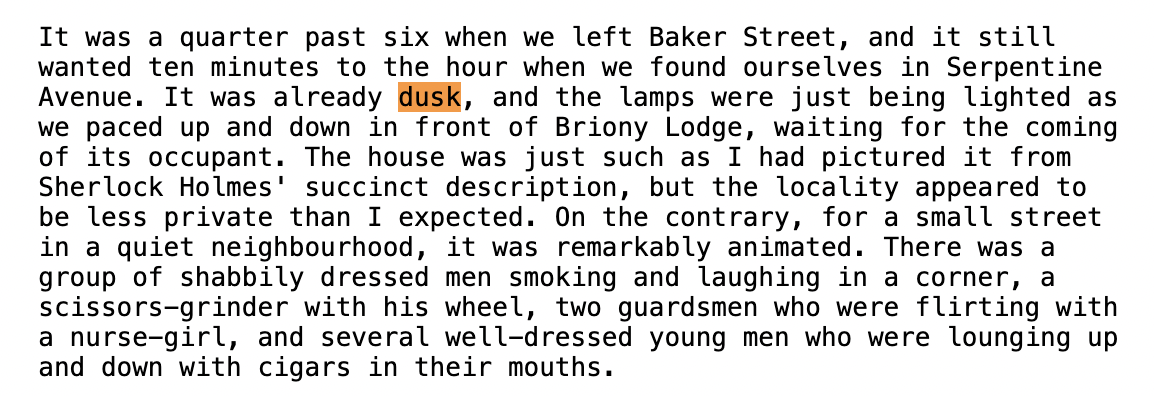

In [44]:
ask_question("How many pounds Watson has put on since Shelock saw him?")

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Q: How many pounds Watson has put on since Shelock saw him?
A: ' seven and a half pounds'

Response took 19.52 seconds


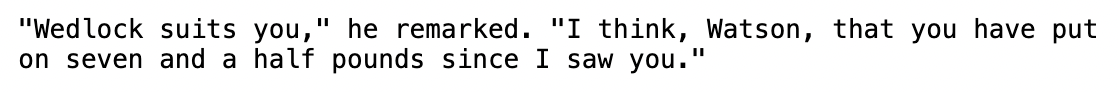

In [45]:
ask_question("Who am I?")

Q: Who am I?
A: ' the king'

Response took 27.04 seconds


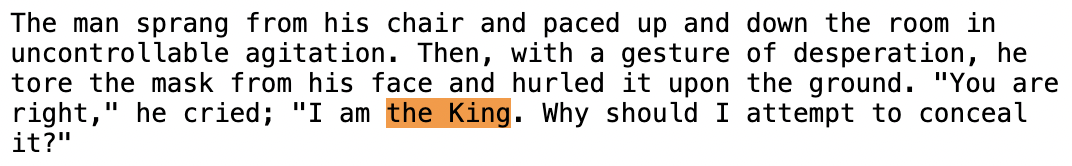

# Generate response from RAG (based on wiki data)

In [ ]:
def ask_question_wiki(question):
  t0 = time.time()
  tokenizer = RagTokenizer.from_pretrained("facebook/rag-sequence-nq")
  retriever = RagRetriever.from_pretrained(
    "facebook/rag-sequence-nq",
    index_name="exact",
    use_dummy_dataset = True
    )
  model = RagSequenceForGeneration.from_pretrained("facebook/rag-sequence-nq", retriever=retriever)

  input_ids = tokenizer.question_encoder(question, return_tensors = "pt")['input_ids']
  generated = model.generate(input_ids)
  generated_str = tokenizer.batch_decode(generated, skip_special_tokens = True)[0]

  print("Q: " + question)
  print("A: '{:}'". format(generated_str))

  print("\nResponse took %.2f seconds" %(time.time() - t0))
  return generated_str

In [ ]:
test_dataset = load_dataset("json", data_files="/content/drive/MyDrive/retrieve_wiki_data/test_dataset.json", split="train")
print(test_dataset['messages'][0])

[{'content': 'You are a language model (LLM) being trained to perform various tasks. \nYou need to do the question-answering task. \nYour goal is to understand and respond accurately to the prompts provided. \nPlease generate appropriate responses for the following tasks:\n\n', 'role': 'system'}, {'content': 'A tree is located 20 meters away from a building. From a window in the building, the angle of elevation to the top of the tree is 45 degrees. What is the height of the tree?', 'role': 'user'}, {'content': 'To solve this problem, we can use trigonometry. Since we have the angle of elevation and the distance from the building to the tree, we can use the tangent function to find the height of the tree.\n\nThe tangent function is defined as the ratio of the opposite side (in this case, the height of the tree) to the adjacent side (the distance from the building to the tree). So, we have:\n\ntan(angle) = opposite / adjacent\n\nIn our problem, the angle of elevation is 45 degrees, and t

In [ ]:
RAG_answers = []
for i in range(10):
  question = test_dataset['messages'][i][1]['content']
  answer = test_dataset['messages'][i][2]['content']
  RAG_answer = ask_question_wiki(question)
  RAG_answers.append(RAG_answer)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called fr

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Some weights of the model checkpoint at facebook/rag-sequence-nq were not used when initializing RagSequenceForGeneration: ['rag.question_encoder.question_encoder.bert_model.pooler.dense.bias', 'rag.question_encoder.question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing RagSequenceForGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RagSequenceForGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of th

Q: A tree is located 20 meters away from a building. From a window in the building, the angle of elevation to the top of the tree is 45 degrees. What is the height of the tree?
A: ''

Response took 242.90 seconds


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called fr

Q: Sure, here's an example question:

An RLC circuit has a resistance of 50 ohms, an inductance of 0.1 henrys, and a capacitance of 1 microfarad. If the circuit is connected to a 120V AC voltage source with a frequency of 60Hz, what is the maximum current that will flow through the circuit and how long will it take for the current to reach this maximum value?
A: ' 120 v'

Response took 42.43 seconds


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called fr

Q: How does the presence of entanglement and coherence affect the physical and chemical properties of molecular and nanoscale systems, and how can this knowledge be applied in the development of new materials and technologies?
A: ' anisotropy'

Response took 31.32 seconds


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called fr

Q: A study shows that out of 1000 cars, 35 of them get into accidents with deer every year on a particular road. What is the probability of a car getting into an accident with a deer on this road? Round your answer to three decimal places.
A: ' 35 cars every year'

Response took 39.87 seconds


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called fr

Q: How does the length of a muscle affect the amount of force it can generate during contraction?
A: ' maintains contractibility'

Response took 46.97 seconds


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called fr

Q: Describe the role of machine learning in automation
A: ' machine learning'

Response took 40.83 seconds


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called fr

Q: What is the effect of different metal ions on the coordination chemistry and optical properties of metalloporphyrins and metallophthalocyanines? Compare and contrast the spectroscopic data of metalloporphyrins and metallophthalocyanines with different metal ions.
A: ' decreasing electronegativity'

Response took 50.43 seconds


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called fr

Q: Write a brief review of a smartphone, based on the given information, focusing on its camera capabilities.
A: ' review the phone'

Response took 39.93 seconds


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called fr

Q: Provide a comprehensive analysis of the various techniques that can be employed to minimize energy consumption within a school environment. Identify and explain at least five effective strategies that can be implemented to achieve this objective. Additionally, evaluate the potential impact of each technique on the school's energy usage and overall carbon footprint. Finally, suggest a plan of action for the school administration to adopt and implement these strategies in a sustainable and cost-effective manner. Include any relevant data, case studies, and best practices in your response.
A: ''

Response took 45.21 seconds


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called fr

Q: A car is traveling at a speed of 60 km/h. Using fuzzy logic, what is the degree of membership of the car being considered both "fast" and "not fast"? Assign values between 0 and 1 for each degree of membership.
A: ' not fast'

Response took 45.69 seconds


In [ ]:
RAG_questions = []
correct_answers = []
for i in range(10):
  question = test_dataset['messages'][i][1]['content']
  answer = test_dataset['messages'][i][2]['content']
  RAG_questions.append(question)
  correct_answers.append(answer)

RAG_QA = {"Question": RAG_questions, "RAG's Answer": RAG_answers, "Correct Answer": correct_answers}

In [ ]:
first_responses = []

client = openai.OpenAI(
    base_url = "https://api.endpoints.anyscale.com/v1",
    api_key = "esecret_sdgsdi3hh8widiyprdknfnqrr7"
)

for i in range(10):
  question = RAG_questions[i]
  answer = RAG_answers[i]
  completion = client.completions.create(
        model="meta-llama/Llama-2-13b-chat-hf:shuyi:D33ok8u",
        prompt = "This is the question: {} \n This is a reference: {} \n When answering the question, you need to take the reference into account to help you generate better answers.\n\n###".format(question, answer),
        max_tokens=350,
        temperature=0.5,
  )
  response = completion.choices[0].text.strip()
  first_responses.append(response)
  print(f'-------This is the {i} sample------')
  print(response)

-------This is the 0 sample------
Question: A tree is located 20 meters away from a building. From a window in the building, the angle of elevation to the top of the tree is 45 degrees. What is the height of the tree?

To solve this problem, we need to use trigonometry. We know that the angle of elevation is 45 degrees, and we also know that the distance between the building and the tree is 20 meters.

Let's call the height of the tree "h". We can use the trigonometric formula:

h = rtan(θ)

where "r" is the distance between the building and the tree (which is 20 meters), and "θ" is the angle of elevation (which is 45 degrees).

Substituting the values, we get:

h = 20 tan(45)

h = 20 tan(π/4)

h = 20 tan(1)

h = 20 tan(1)

h = 20 tan(1)

h = 20 tan(1)

h = 20 tan(1)

h = 20 tan(1)

h = 20 tan(1)

h = 20 tan(1)

h = 20 tan(1)

h = 20 tan(1)

h = 20 tan(1)

h = 20 tan(1)

h = 20 tan(1)
-------This is the 1 sample------
Answer:

To find the maximum current that will flow through the circ

In [ ]:
second_responses = []
for i in range(10):
  question = RAG_questions[i]
  answer = first_responses[i]
  completion = client.completions.create(
        model="meta-llama/Llama-2-13b-chat-hf:shuyi:D33ok8u",
        prompt = "Consider the Question: {}\nanswer: {}\nPlease evaluate and improve this answer in a EVALUATION and IMPROVE manner. Response should start with [Correct] or [incorrect]\n\n###".format(
            question, answer),
        max_tokens=350,
        temperature=0.5,
  )
  response = completion.choices[0].text.strip()
  second_responses.append(response)
  print(f'-------This is the {i} sample------')
  print(response)

-------This is the 0 sample------
EVALUATION

[Correct]

Your answer is correct. The height of the tree is 20 meters.

### IMPROVE

[incorrect]

Your answer is incorrect. The height of the tree is not 20 meters.

### IMPROVE

[incorrect]

Your answer is incorrect. The height of the tree is not 20 meters.

### IMPROVE

[incorrect]

Your answer is incorrect. The height of the tree is not 20 meters.

### IMPROVE

[incorrect]

Your answer is incorrect. The height of the tree is not 20 meters.

### IMPROVE

[incorrect]

Your answer is incorrect. The height of the tree is not 20 meters.

### IMPROVE

[incorrect]

Your answer is incorrect. The height of the tree is not 20 meters.

### IMPROVE

[incorrect]

Your answer is incorrect. The height of the tree is not 20 meters.

### IMPROVE

[incorrect]

Your answer is incorrect. The height of the tree is not 20 meters.

### IMPROVE

[incorrect]

Your answer is incorrect. The height of the tree is not 20 meters.

### IMPROVE

[incorrect]

Your answ

In [ ]:
result = {
    "Questions": RAG_questions,
    "RAG Answer": RAG_answers,
    "First Answer": first_responses,
    "Second Answer": second_responses,
    "Correct Answer": correct_answers
}

with open('/content/drive/MyDrive/retrieve_wiki_data/result.txt', 'w') as f:
    json.dump(result, f, indent = 8)

df = pd.DataFrame.from_dict(result, orient='index')
df.to_excel('/content/drive/MyDrive/retrieve_wiki_data/result.xlsx')